# Experiments with the LIME interpretation model

In this blog post I will share some experiments on the LIME interpretation model. LIME was introduced in 2016 by Marco Ribeiro and his collaborators in a paper called [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938). Its purpose is to explain a model prediction for a specific sample in a human-interpretable way. It provides a way to investigate a model predictions beyond the sole classification or regression metric. 

In order to set the playground I first build a quick model on the [IMDB](www.imdb.com) sentiment analysis dataset, which contains movie reviews with an associated sentiment (0 for negative, 1 for positive). Data was downloaded [on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/download/labeledTrainData.tsv.zip). 


In [1]:
import pandas as pd
df = pd.read_csv('./labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


## Text preprocessing

Here I simply replace rare words with an "oov" (out-of-vocabulary) tag. This step is crucial as rare words (tipically less than 10 occurences) do not appear often enough for the model to learn pattern with it, and they increase the vector space representation dimension dramatically with most text vectorization method (such as bag-of-words or TF-IDF).

In [2]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

texts = [t.lower() for t in df['review'].values]
y = df['sentiment'].values

# 1) Compute word frequencies
all_tokens = [token for t in texts for token in t.split()] 
frequencies = defaultdict(int)
for w in all_tokens:
    frequencies[w] += 1
print('Vocabulary size before rare words tagging:', len(set(all_tokens)))

# 2) Replace words occuring less than 20 times in the corpus with an out-of-vocabulary tag 
texts = [' '.join([w if frequencies[w] > 20 else '<oov>' 
                   for w in t.split()])
         for t in texts]
print('Vocabulary size after rare words tagging:', len(set([token for t in texts for token in t.split()])))

# 3) Split train and test sets (should be done before rare words tagging in real world applications)
texts_train, texts_test, y_train, y_test = train_test_split(texts, y)

Vocabulary size before rare words tagging: 257663
Vocabulary size after rare words tagging: 15351


## Building a simple sentiment prediction pipeline
Here I build a simple data transformation pipeline for text classification: a [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) vectorizer followed by a random forest classifier. 

This classification pipeline is prettty standard but it is already hard to interpret.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

vectorizer = TfidfVectorizer()
classifier = RandomForestClassifier(n_estimators=100, max_depth=5)

pipeline = make_pipeline(vectorizer, classifier)

pipeline.fit(texts_train, y_train)
y_preds = pipeline.predict(texts_test)

print('Accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))
print('F1-score: {:.2f} %'.format(100*metrics.f1_score(y_preds, y_test)))

Accuracy: 81.10 %
F1-score: 81.66 %


## Analysis: what has the model learnt?
A F1-score of 80% is already enjoyable for some classification tasks, but we have no idea if the classifier has learnt useful features yet. For instance an additional HTML tag may have been added to the positive examples for obscure reasons, in which case our classifier would have a nice score but would have mostly learnt to recognize this artificial tag presence. This situation happens more very often in data science has some variable "from the future" sometimes leak in your dataset. 

To avoid such ungeneralizable model training, one has to investigate the model prediction in addition to the computation of the score on a test set.

### Feature importance

A standard way to understand the predictions of a trained random forest classifier is to compute feature (Gini) importance. Feature importance in trees is computed as the (normalized) mean Gini impurity reduction brought by the features. In a word it describes how well the feature splits classes in your trees. 

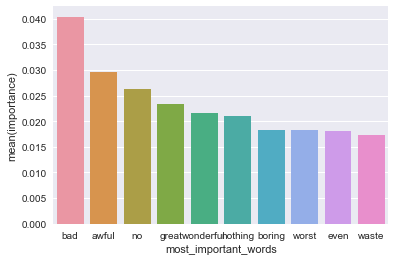

In [4]:
import seaborn as sns
%matplotlib inline

# Create a dictionary with most important features
importances = pipeline.named_steps['randomforestclassifier'].feature_importances_
top_indices = np.argsort(importances)[::-1][:10]
words_importance = pd.DataFrame({'most_important_words': np.array(vectorizer.get_feature_names())[top_indices],
                                 'importance': importances[top_indices]})

sns.barplot(x="most_important_words", y="importance", data=words_importance);
plt.title('')

So now we have the most important words on average on the training set. The most important words make sense, but
* We don't know if a word contributes positively or negatively
* The feature importance attribute is specific to tree-based models
* If we don't undestand a specific prediction, it is hard to investigate the decision of the model

For the last point there is a work-around: we can compute the model importance of the words that are present in a specific text. 

Here is an example:

In [5]:
# We choose a sample from test set
idx = 4
text_sample = texts_test[idx]
class_names = ['negative', 'positive']

print(text_sample)
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

every great gangster movie has <oov> of human drama. don't expect an emotional story of guilt, <oov> and despair from <oov> this is a tale of <oov> <oov> corruption, and power. the darker side of the <oov> \"american <oov> /><br <oov> complaining about the <oov> of this film is missing the point. the superficial characters, cheesy music, and dated fashions further fuel the criticism of this life of diabolical <oov> nothing in the lives of these characters really matter, not on any human level at least. in fact the film practically <oov> satire, ironic considering all the <oov> <oov> that were positively inspired by the lifestyle of tony <oov> /><br />this isn't brian <oov> strongest directorial effort, it is occasionally excellent and <oov> (particularly the memorable <oov> but frequently sinks to sloppy and <oov> thankfully, it is supported by a very strong script by oliver stone (probably good therapy for him, considering the coke habit he was <oov> at the time). the themes are <oov>

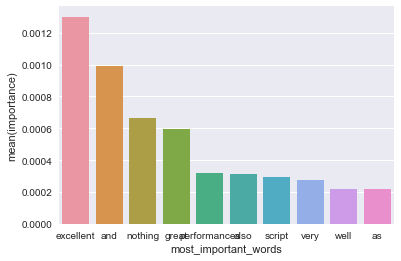

In [6]:
sample_importances = (vectorizer.transform([text_sample]).toarray()*importances).flatten()
sample_top_indices = np.argsort(sample_importances)[::-1][:10]
sample_words_importance = pd.DataFrame(
    {'most_important_words': np.array(vectorizer.get_feature_names())[sample_top_indices],
    'importance': sample_importances[sample_top_indices]})

sns.barplot(x="most_important_words", y="importance", data=sample_words_importance)

### Example specific analysis with LIME
In their article [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938), Marco Ribeiro and his collaborators introduce a new framework for machine learning models interpretation called LIME (Local Interpretable Model-agnostic Explanations). 

The purpose of LIME is to give an interpretable explanation for a given input sample prediction, by approximating the model to be explained $f$ by an "explanation model" $g$ that is linear and has an interpretable domain. While your original model may operate on a complex vector space such as the TF-IDF representation of a text, or the HOG features of a picture, the explanation model's domain is a human interpretable one, such as a vector indicating the presence or absence of a few critical words in a text.

LIME requires:
* a mapping $x\rightarrow x'$ of the model input vector to an interpretable representation $\{0,1\}^{d'}$. Here, while the original $x$ may be a complex vector in $\mathbb{R}^n$, the vector $x'$ just indicates the absence/ presence of basic features (words for text, pixels for pictures).
* A proximity measure function $\Pi_{x}$ measuring closeness to the sample $x$ under scrutiny. Usually a normal distribution over the distance (cosine distance for texts, L2-norm for pictures) 
* A choice for the interpetable model $g$. The first choice is a linear model (i.e. a linear regression for regression and a logistic regression for classification).


Technically, LIME optimizes the sum of the local fidelity $$\mathcal{L}(f, g, \Pi_x)= \sum_{z, z'} \Pi_x(z) \left[f(z) - g(z') \right]^2$$ 
under the constraint to have less than $K$ non-zero weights. Simple examples can be found on the [Github repository of the project](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html).


/Users/nthiebaut/anaconda/envs/nlp/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


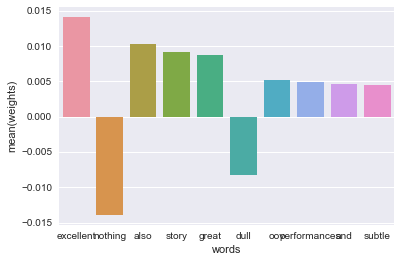

In [7]:
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);

LIME managed to extract mostly the same important word as the model itself, without knowing anything about it! We now have rational numbers, allowing the human interpreter to understand what words were the most important. Also, this technique can be replicated instantly for any model, so let's try with a neural network! (next blog post :)